In [1]:
!wget https://github.com/imguru-mooc/AI_VISION/raw/main/4_day/1.YOLOv1/1.YOLOv1.zip

--2023-10-18 23:09:30--  https://github.com/imguru-mooc/AI_VISION/raw/main/4_day/1.YOLOv1/1.YOLOv1.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/imguru-mooc/AI_VISION/main/4_day/1.YOLOv1/1.YOLOv1.zip [following]
--2023-10-18 23:09:30--  https://raw.githubusercontent.com/imguru-mooc/AI_VISION/main/4_day/1.YOLOv1/1.YOLOv1.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11283 (11K) [application/zip]
Saving to: ‘1.YOLOv1.zip’

1.YOLOv1.zip        100%[===================>]  11.02K  --.-KB/s    in 0s      

2023-10-18 23:09:30 (108 MB/s) - ‘1.YOLOv1.zip’ saved [11283/11283]



In [2]:
!unzip 1.YOLOv1.zip

Archive:  1.YOLOv1.zip
   creating: data/
  inflating: data/generate_csv.py    
  inflating: data/get_data.sh        
  inflating: data/voc_label.py       
  inflating: dataset.py              
  inflating: loss.py                 
  inflating: model.py                
  inflating: train.py                
  inflating: utils.py                


In [3]:
!bash data/get_data.sh

--2023-10-18 23:09:49--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  23.3MB/s    in 21s     

2023-10-18 23:10:11 (20.5 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2023-10-18 23:10:11--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================

In [9]:
"""
Main file for training Yolo model on Pascal VOC dataset
"""

import torch
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from model import Yolov1
from dataset import VOCDataset
from utils import (
    non_max_suppression,
    mean_average_precision,
    intersection_over_union,
    cellboxes_to_boxes,
    get_bboxes,
    plot_image,
    save_checkpoint,
    load_checkpoint,
)
from loss import YoloLoss

seed = 123
torch.manual_seed(seed)

# Hyperparameters etc.
LEARNING_RATE = 2e-5
DEVICE = "cuda" if torch.cuda.is_available else "cpu"
BATCH_SIZE = 32 # 64 in original paper but I don't have that much vram, grad accum?
WEIGHT_DECAY = 0
EPOCHS = 50
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth.tar"
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"


class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes


transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])


def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(DEVICE), y.to(DEVICE)
        out = model(x)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update progress bar
        loop.set_postfix(loss=loss.item())

    print(f"Mean loss was {sum(mean_loss)/len(mean_loss)}")


def main():

    optimizer = optim.Adam(
        model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY
    )
    loss_fn = YoloLoss()

    if LOAD_MODEL:
        load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)

    train_dataset = VOCDataset(
        "data/train.csv",
        transform=transform,
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
    )

    test_dataset = VOCDataset(
        "data/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
    )

    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=BATCH_SIZE,
        num_workers=NUM_WORKERS,
        pin_memory=PIN_MEMORY,
        shuffle=True,
        drop_last=True,
    )



    for epoch in range(EPOCHS):
        # for x, y in train_loader:
        #    x = x.to(DEVICE)
        #    for idx in range(8):
        #        bboxes = cellboxes_to_boxes(model(x))
        #        bboxes = non_max_suppression(bboxes[idx], iou_threshold=0.5, threshold=0.4, box_format="midpoint")
        #        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

        #    import sys
        #    sys.exit()

        pred_boxes, target_boxes = get_bboxes(
            train_loader, model, iou_threshold=0.5, threshold=0.4
        )

        mean_avg_prec = mean_average_precision(
            pred_boxes, target_boxes, iou_threshold=0.5, box_format="midpoint"
        )
        print(f"Epoch: {epoch} , Train mAP: {mean_avg_prec}")

        #if mean_avg_prec > 0.9:
        #    checkpoint = {
        #        "state_dict": model.state_dict(),
        #        "optimizer": optimizer.state_dict(),
        #    }
        #    save_checkpoint(checkpoint, filename=LOAD_MODEL_FILE)
        #    import time
        #    time.sleep(10)

        train_fn(train_loader, model, optimizer, loss_fn)

In [10]:
if __name__ == "__main__":
    model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
    main()

Epoch: 0 , Train mAP: 0.0


100%|██████████| 78/78 [00:49<00:00,  1.57it/s, loss=492]

Mean loss was 972.6475681402744


Epoch: 1 , Train mAP: 0.00048761963262222707


100%|██████████| 78/78 [00:51<00:00,  1.53it/s, loss=488]

Mean loss was 469.32528334397534


Epoch: 2 , Train mAP: 0.0022821619641035795


100%|██████████| 78/78 [00:52<00:00,  1.50it/s, loss=368]

Mean loss was 362.12603251139325


Epoch: 3 , Train mAP: 0.004684620536863804


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=301]

Mean loss was 322.9230720324394


Epoch: 4 , Train mAP: 0.010834755375981331


100%|██████████| 78/78 [00:52<00:00,  1.50it/s, loss=294]

Mean loss was 293.8842912331606


Epoch: 5 , Train mAP: 0.035409752279520035


100%|██████████| 78/78 [00:51<00:00,  1.50it/s, loss=351]

Mean loss was 270.8568850786258


Epoch: 6 , Train mAP: 0.06168995052576065


100%|██████████| 78/78 [00:52<00:00,  1.49it/s, loss=224]

Mean loss was 251.58708934294873


Epoch: 7 , Train mAP: 0.06402094662189484


100%|██████████| 78/78 [00:51<00:00,  1.50it/s, loss=280]

Mean loss was 230.55942946213943


Epoch: 8 , Train mAP: 0.054646361619234085


100%|██████████| 78/78 [00:52<00:00,  1.50it/s, loss=221]

Mean loss was 216.90101662660257


Epoch: 9 , Train mAP: 0.1907608062028885


100%|██████████| 78/78 [00:52<00:00,  1.50it/s, loss=203]

Mean loss was 199.4867414816832


Epoch: 10 , Train mAP: 0.2611827850341797


100%|██████████| 78/78 [00:51<00:00,  1.51it/s, loss=214]

Mean loss was 187.96606817000952


Epoch: 11 , Train mAP: 0.28754568099975586


100%|██████████| 78/78 [00:55<00:00,  1.40it/s, loss=126]

Mean loss was 173.88709748096954


Epoch: 12 , Train mAP: 0.33789190649986267


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=178]

Mean loss was 163.20339799538638


Epoch: 13 , Train mAP: 0.453997939825058


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=135]

Mean loss was 155.63992544320914


Epoch: 14 , Train mAP: 0.5455448627471924


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=112]

Mean loss was 147.86958557520157


Epoch: 15 , Train mAP: 0.550025224685669


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=124]

Mean loss was 142.2757513584235


Epoch: 16 , Train mAP: 0.537131667137146


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=144]

Mean loss was 137.70768600855118


Epoch: 17 , Train mAP: 0.6415563225746155


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=153]

Mean loss was 131.37169158153046


Epoch: 18 , Train mAP: 0.6640385389328003


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=126]

Mean loss was 127.42468936626727


Epoch: 19 , Train mAP: 0.7072492837905884


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=180]

Mean loss was 125.2996086707482


Epoch: 20 , Train mAP: 0.6495712995529175


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=113]

Mean loss was 119.97270662356645


Epoch: 21 , Train mAP: 0.5924227237701416


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=105]

Mean loss was 115.35274975116437


Epoch: 22 , Train mAP: 0.6640939116477966


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=90.4]

Mean loss was 111.93752269255809


Epoch: 23 , Train mAP: 0.7415115237236023


100%|██████████| 78/78 [00:55<00:00,  1.40it/s, loss=124]

Mean loss was 109.25352409558418


Epoch: 24 , Train mAP: 0.7140946984291077


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=79.1]

Mean loss was 105.26003167568109


Epoch: 25 , Train mAP: 0.7772879600524902


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=76.4]

Mean loss was 99.45408239120093


Epoch: 26 , Train mAP: 0.7837487459182739


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=104]

Mean loss was 101.0106333219088


Epoch: 27 , Train mAP: 0.7738043069839478


100%|██████████| 78/78 [00:55<00:00,  1.40it/s, loss=153]

Mean loss was 102.84621453896547


Epoch: 28 , Train mAP: 0.7761362791061401


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=81.4]

Mean loss was 98.0965583996895


Epoch: 29 , Train mAP: 0.7502957582473755


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=108]

Mean loss was 93.26624748034355


Epoch: 30 , Train mAP: 0.7746255993843079


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=101]

Mean loss was 91.81257081643129


Epoch: 31 , Train mAP: 0.7950897216796875


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=102]

Mean loss was 87.5620361719376


Epoch: 32 , Train mAP: 0.8052221536636353


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=99.6]

Mean loss was 102.36096920111241


Epoch: 33 , Train mAP: 0.7646815180778503


100%|██████████| 78/78 [00:55<00:00,  1.40it/s, loss=81.9]

Mean loss was 91.63920671511919


Epoch: 34 , Train mAP: 0.7946962118148804


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=59.6]

Mean loss was 84.27838785220415


Epoch: 35 , Train mAP: 0.7850538492202759


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=98.1]

Mean loss was 81.49879509363419


Epoch: 36 , Train mAP: 0.8126167058944702


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=94.4]

Mean loss was 77.68297131856282


Epoch: 37 , Train mAP: 0.8005455136299133


100%|██████████| 78/78 [00:55<00:00,  1.40it/s, loss=73.1]

Mean loss was 76.30806453411395


Epoch: 38 , Train mAP: 0.7962872385978699


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=55.5]

Mean loss was 74.6532593751565


Epoch: 39 , Train mAP: 0.8284064531326294


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=62.7]

Mean loss was 72.0868448599791


Epoch: 40 , Train mAP: 0.8306664228439331


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=67.3]

Mean loss was 70.63745782314203


Epoch: 41 , Train mAP: 0.8331362009048462


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=81.5]

Mean loss was 71.56756493984125


Epoch: 42 , Train mAP: 0.8462713360786438


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=86.8]

Mean loss was 68.33621431008363


Epoch: 43 , Train mAP: 0.845822811126709


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=43.3]

Mean loss was 66.21113248971793


Epoch: 44 , Train mAP: 0.8514953851699829


100%|██████████| 78/78 [00:55<00:00,  1.40it/s, loss=76]

Mean loss was 70.57042263715695


Epoch: 45 , Train mAP: 0.8006209135055542


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=58.3]

Mean loss was 69.74976211939102


Epoch: 46 , Train mAP: 0.8243346214294434


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=60.6]

Mean loss was 61.83310841291379


Epoch: 47 , Train mAP: 0.8294610977172852


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=54.5]

Mean loss was 62.42696409959059


Epoch: 48 , Train mAP: 0.8177086114883423


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=57.5]

Mean loss was 60.62199543683957


Epoch: 49 , Train mAP: 0.8365945816040039


100%|██████████| 78/78 [00:55<00:00,  1.41it/s, loss=69.3]

Mean loss was 59.27875685080504


In [11]:
torch.save(model.state_dict(), "yolov1.pt")

In [12]:
model = Yolov1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
model.load_state_dict(torch.load("yolov1.pt"))

<All keys matched successfully>

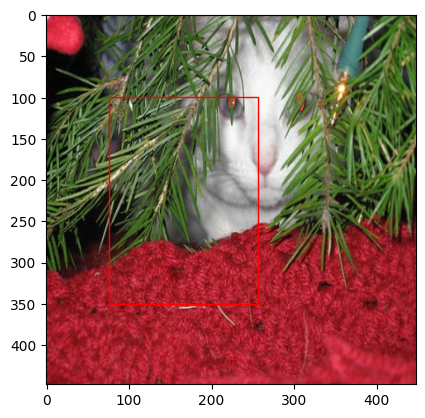

[[14.0, 0.41198059916496277, 0.3709479868412018, 0.5010859966278076, 0.40455108880996704, 0.5599625110626221]]


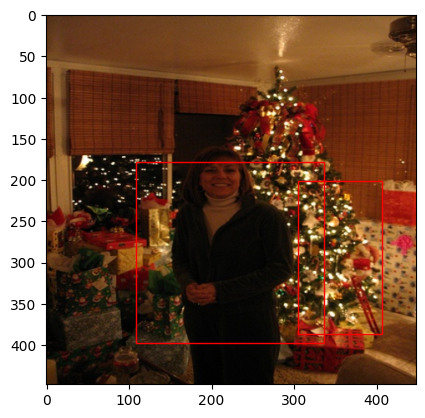

[[11.0, 0.4876214265823364, 0.7945080995559692, 0.6547656059265137, 0.22575189173221588, 0.4136086404323578], [14.0, 0.46263009309768677, 0.49557074904441833, 0.6429608464241028, 0.5077697038650513, 0.49016475677490234]]


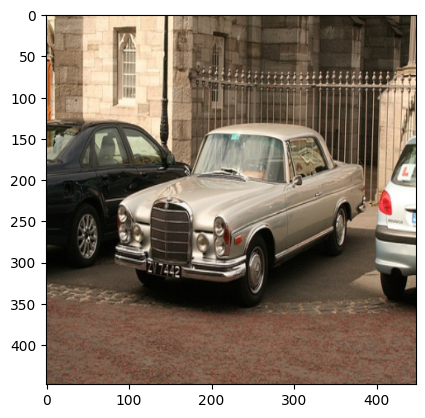

[]


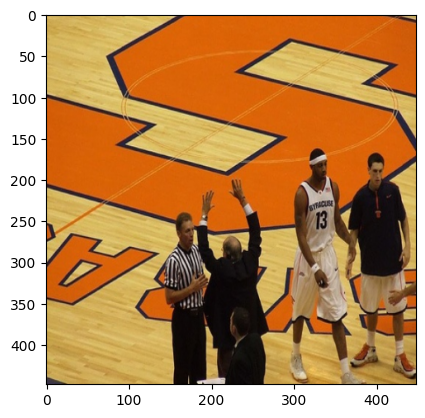

[]


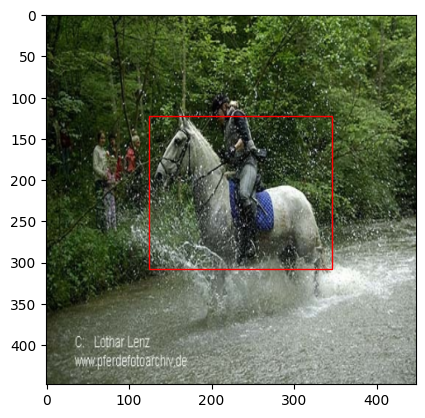

[[2.0, 0.5032824873924255, 0.5246626138687134, 0.48043978214263916, 0.4940263628959656, 0.41541263461112976]]


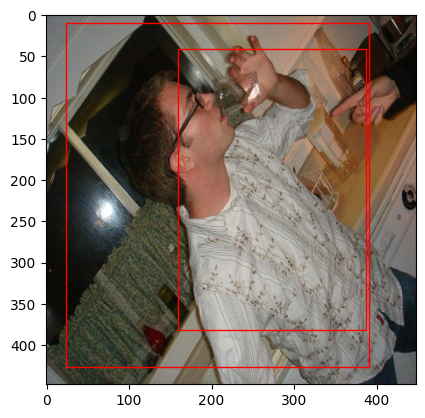

[[7.0, 0.7290027141571045, 0.4629732072353363, 0.4866746962070465, 0.821603536605835, 0.9311628341674805], [14.0, 0.46543318033218384, 0.6102656126022339, 0.4719630181789398, 0.5071294903755188, 0.7613400220870972]]


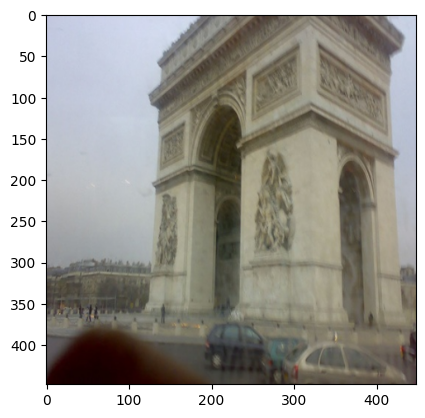

[]


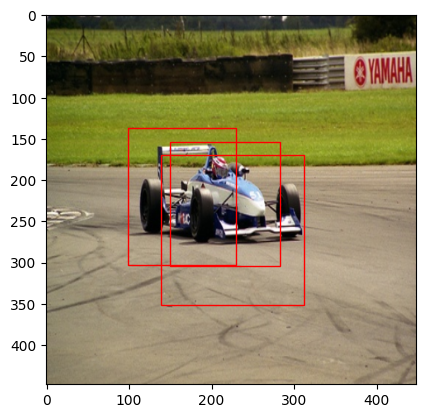

[[6.0, 0.48661550879478455, 0.36656269431114197, 0.49072059988975525, 0.2917623221874237, 0.3721206784248352], [6.0, 0.4444967210292816, 0.502098560333252, 0.5814781188964844, 0.38652557134628296, 0.40462884306907654], [14.0, 0.43681034445762634, 0.48290514945983887, 0.5107426643371582, 0.2991132438182831, 0.33621570467948914]]


In [14]:
test_dataset = VOCDataset(
    "data/test.csv", transform=transform, img_dir=IMG_DIR, label_dir=LABEL_DIR,
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=8,
    num_workers=NUM_WORKERS,
    pin_memory=PIN_MEMORY,
    shuffle=True,
    drop_last=True,
)

model.eval()

(x, labels) = next(iter(test_loader))
x = x.to(DEVICE)
labels = labels.to(DEVICE)

with torch.no_grad():
    predictions = model(x)

batch_size = x.shape[0]
true_bboxes = cellboxes_to_boxes(labels)
bboxes = cellboxes_to_boxes(predictions)

all_pred_boxes = []
all_true_boxes = []
train_idx = 0

iou_threshold=0.5
threshold=0.4
box_format="midpoint"

for idx in range(batch_size):
    nms_boxes = non_max_suppression(
        bboxes[idx],
        iou_threshold=iou_threshold,
        threshold=threshold,
        box_format=box_format,
    )

    plot_image(x[idx].permute(1,2,0).to("cpu"), nms_boxes)
    print(nms_boxes)